In [86]:
import pickle as pkl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import utils
import models
import GraphKernel

In [87]:
path = 'data/'
with open(path + 'training_data.pkl', 'rb') as file: 
    train_graphs = pkl.load(file) 

with open(path + 'test_data.pkl', 'rb') as file: 
    test_graphs = pkl.load(file) 
    
with open(path + 'training_labels.pkl', 'rb') as file: 
    train_labels = pkl.load(file) 

In [88]:

for G in train_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1

for G in test_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1


In [89]:
one_train = []
zero_train = []
for (i,G) in enumerate(train_graphs):
    if(train_labels[i] == 0):
        zero_train.append(G)
    else:
        one_train.append(G)    

In [90]:
n = 6000
train_graphs = one_train
train_labels = [1]*len(one_train)
for G in zero_train:
    if(len(train_graphs) == n):
        break
    train_graphs.append(G)
    train_labels.append(0)


In [91]:
zero_train = zero_train[n:]
y_zeros = np.zeros(len(zero_train))

In [92]:
len(zero_train)

0

In [93]:
#from grakel import ShortestPath
#gk = ShortestPath(with_labels=True)
#K_train = gk.fit_transform(train_graphs)

randomWalk =  GraphKernel.WalkKernel(maxK = 3)#GraphKernel.ShortestPath()#
K_train = randomWalk.compute_kernel(train_graphs,train_graphs) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_graphs, train_labels, test_size=0.3, random_state=100,stratify=train_labels)
X_train_K = randomWalk.compute_kernel(X_train,X_train)
X_test_K = randomWalk.compute_kernel(X_test,X_train)
K_zero = randomWalk.compute_kernel(zero_train,train_graphs)


100%|██████████| 1800/1800 [00:36<00:00, 49.95it/s]
0it [00:00, ?it/s]


In [159]:
C = 0.03

In [145]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf, scoring = 'roc_auc')
print(score)
print(np.mean(score))

print("recall")
score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf,scoring='recall')
print(score)
print(np.mean(score))

print("precision")
score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf,scoring='precision')
print(score)
print(np.mean(score))

[0.85538845 0.88735843 0.88717643 0.88622507 0.83725875]
0.8706814252268797
recall
[0.13513514 0.17117117 0.14414414 0.07207207 0.09009009]
0.12252252252252252
precision
[0.83333333 0.61290323 0.72727273 0.8        0.83333333]
0.7613685239491692


In [139]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, train_labels)

if(K_zero.shape[0] > 0):
    # Predict and test.
    y_pred = clf.predict(K_zero)

    print("Classification accuracy: %0.2f" % accuracy_score(y_zeros, y_pred))

In [140]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
if(K_zero.shape[0] > 0):
    y_pred = clf.predict(K_zero)
    #tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
    confusion_matrix = confusion_matrix(y_zeros, y_pred,normalize='true')
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

In [141]:
if(K_zero.shape[0] > 0):
    from sklearn.metrics import plot_roc_curve, auc 
    plot_roc_curve(clf, K_zero, y_zeros)

Classification accuracy: 0.92


C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


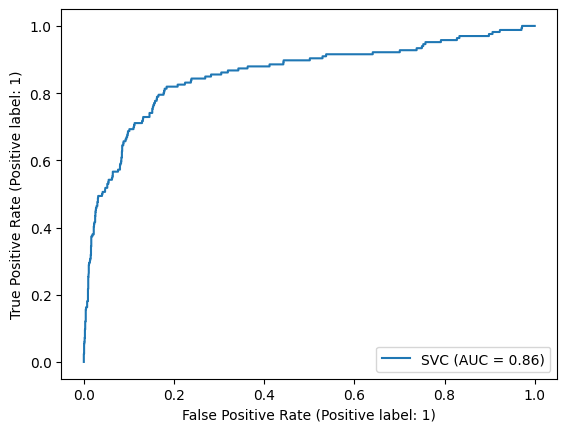

In [147]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(X_train_K, y_train)

# Predict and test.
y_pred = clf.predict(X_test_K)

print("Classification accuracy: %0.2f" % accuracy_score(y_test, y_pred))
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)


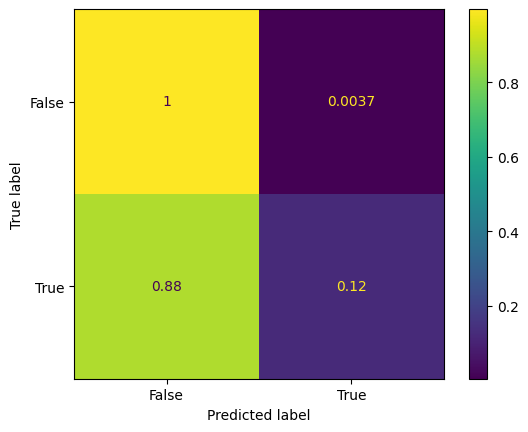

In [148]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(X_test_K)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_test, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


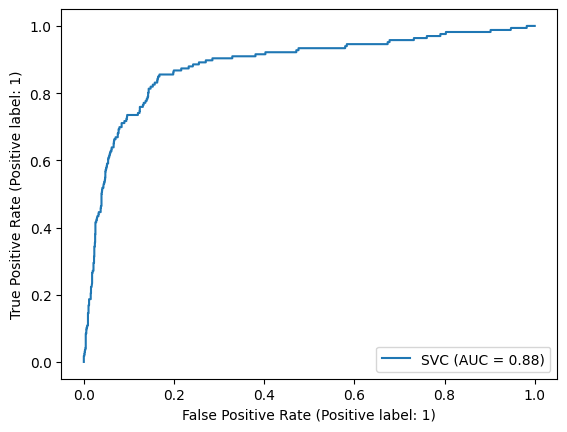

In [144]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)

In [102]:
asdas

NameError: name 'asdas' is not defined

In [149]:
K_train = randomWalk.compute_kernel(train_graphs,train_graphs)
K_train

100%|██████████| 6000/6000 [02:40<00:00, 37.33it/s]


array([[14820.,  1443.,  5736., ...,    77.,   327.,   526.],
       [ 1443.,  3092.,  3256., ...,    45.,  1743.,   228.],
       [ 5736.,  3256.,  6926., ...,    98.,  1878.,   500.],
       ...,
       [   77.,    45.,    98., ...,    68.,    88.,    78.],
       [  327.,  1743.,  1878., ...,    88.,  1600.,   148.],
       [  526.,   228.,   500., ...,    78.,   148.,   288.]])

In [150]:
K_test = randomWalk.compute_kernel(test_graphs,train_graphs)

100%|██████████| 2000/2000 [01:08<00:00, 29.12it/s]


In [151]:
y_train = train_labels
y_train = np.array(y_train).reshape(-1)

In [160]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, y_train)

# Predict and test.
y_pred = clf.predict(K_train)

print("Classification accuracy: %0.2f" % accuracy_score(y_train, y_pred))

Classification accuracy: 0.87


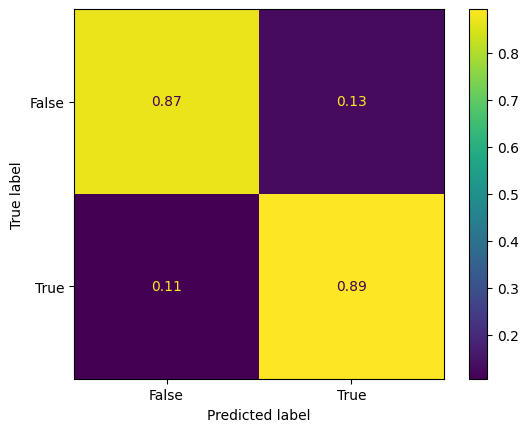

In [161]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(K_train)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_train, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


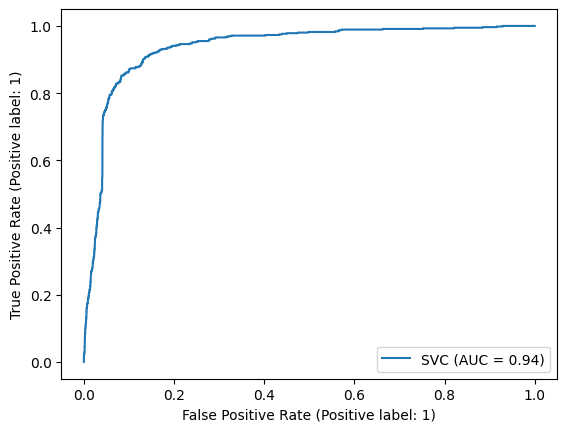

In [162]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, K_train, y_train)

In [163]:
y_pred = clf.predict_proba(K_test)[:,1]
y_pred = np.log(y_pred/(1-y_pred))
y_pred

array([-3.55703038, -1.06232562, -2.45454662, ..., -3.42836751,
       -0.07757371, -3.37287644])

In [164]:
sub = pd.DataFrame()
sub['Id']= np.arange(1,len(y_pred)+1)
sub['Predicted'] = y_pred
sub.to_csv("submissions/sub.csv",index=False)

In [165]:
y_sub = pd.read_csv("submissions/sub.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.122

In [166]:
y_sub = pd.read_csv("submissions/sub_0849.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.1085